###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018 D. Koehn, notebook style sheet by L.A. Barba, N.C. Clementi

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())

# Triangular mesh generation

In the last lesson we learned how to create a quad mesh by Transfinite Interpolation to accurately approximate the strong topography of a sea dike. We can use this mesh for spectral element modelling. But what should we do, if we need a triangular mesh for example for Finite Element modelling?

## Yigma Tepe - another problem with strong topography

You might think that the sea dike topography was already quite complex. Well, here is another problem we are currently working on at the "Applied Geophysics" group at Christian-Albrechts University Kiel:

<img src="images/yigmatepe_1.jpg" width="100%">

This is [Yigma Tepe](https://vici.org/vici/42048/?lang=en), a tumulus which might be a burial of an Attilad King located in Pergamon (Turkey). Extensive [geophysical prospecting](https://publications.dainst.org/journals/index.php/efb/article/view/1562/4464) and [archaeological excavations](https://www.archaeologie-online.de/nachrichten/neue-forschungen-zu-den-antiken-grabhuegeln-der-welterbestaette-pergamon-2937/) revealed small scale near-surface structures, which makes Yigma Tepe an ideal target to further develop 2D SH and 3D seismic full waveform inversion in the field of archaeological prospection. A critical part is the correct discretization of the complex free-surface topography, crucial for accurate modelling of surface waves. 

Let's take a look at a 2D quad mesh created by Transfinite-Interpolation for a SH-profile along the tumulus.

In [2]:
# Import Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Here, I introduce a new library, which is useful 
# to define the fonts and size of a figure in a notebook
from pylab import rcParams

# Get rid of a Matplotlib deprecation warning
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load Yigma Tepe quad mesh created by TFI
X = np.loadtxt('data/yigma_tepe_TFI_mesh_X.dat', delimiter=' ', skiprows=0, unpack='True')
Z = np.loadtxt('data/yigma_tepe_TFI_mesh_Z.dat', delimiter=' ', skiprows=0, unpack='True')

# number of grid points in each spatial direction
NZ, NX = np.shape(X)
print("NX = ", NX)
print("NZ = ", NZ)

NX =  70
NZ =  10


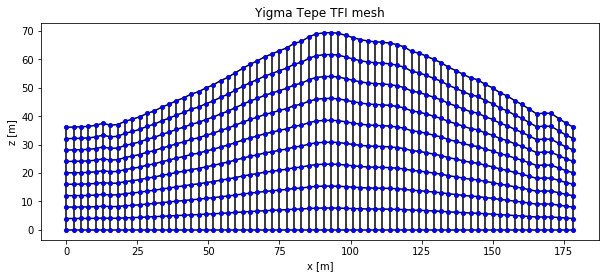

In [4]:
# Define figure size
rcParams['figure.figsize'] = 10, 7

# Plot Yigma Tepe TFI mesh
plt.plot(X, Z, 'k')
plt.plot(X.T, Z.T, 'k')
plt.plot(X, Z, 'bo', markersize=4)

plt.title("Yigma Tepe TFI mesh" )
plt.xlabel("x [m]")
plt.ylabel("z [m]")
plt.axes().set_aspect('equal')
#plt.savefig('yigma_tepe_TFI.pdf', bbox_inches='tight', format='pdf')
plt.show()

This quad mesh is already able to accurately describe the free-surface topography. 

## Triangular mesh generation

If we need a triangular mesh, for example for finite element or finite volume modelling,  we could apply **Delaunay triangulation** to the node point distribution of the Yigma Tepe TFI mesh. For further details related to Delaunay triangulation, I refer to [Computational Geometry in Python](http://blancosilva.github.io/post/2014/10/28/Computational-Geometry-in-Python.html) by Francisco Blanco-Silva. 

In a first step, we assemble the x- and z-vectors in a (NX*NZ x 2) matrix.

In [5]:
# Reshape X and Z vector
x = X.flatten()
z = Z.flatten()

# Assemble x and z vector into NX*NZ x 2 matrix
points = np.vstack([x,z]).T

Next, we compute the **Voronoi diagram** for the mesh points. This describes the partitioning of a plane with n points into convex polygons such that each polygon contains exactly one generating point and every point in a given polygon is closer to its generating point than to any other.

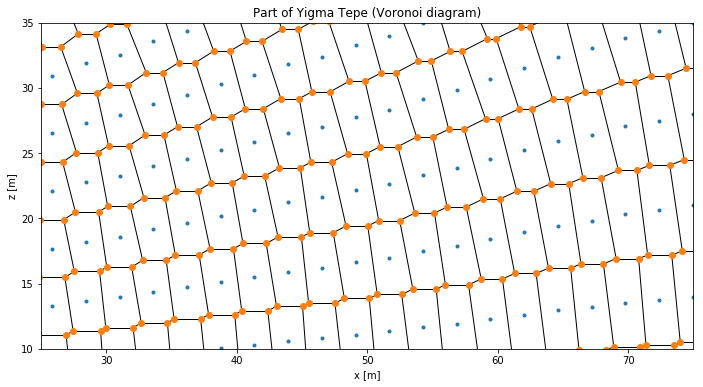

In [6]:
# calculate and plot Voronoi diagram for mesh points
from scipy.spatial import Voronoi, voronoi_plot_2d

vor = Voronoi(points)

plt.figure(figsize=(12,6))
ax = plt.subplot(111, aspect='equal')
voronoi_plot_2d(vor, ax=ax)

plt.title("Part of Yigma Tepe (Voronoi diagram)" )
plt.xlabel("x [m]")
plt.ylabel("z [m]")
plt.xlim( 25,  75)
plt.ylim(10, 35)
plt.show()

The **Delaunay triangulation** creates triangles by connecting the points in neighbouring Voronoi cells.

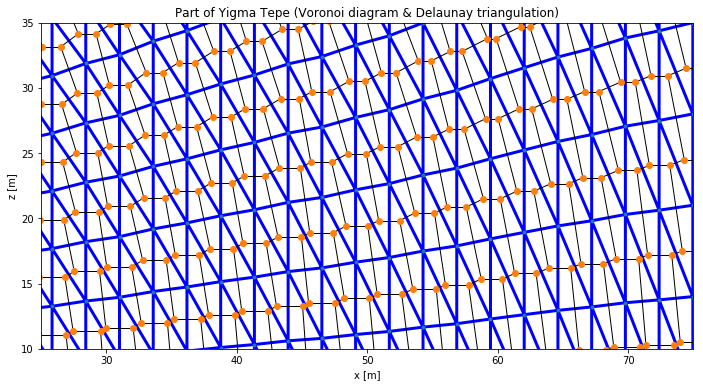

In [7]:
# Apply Delaunay triangulation to the quad mesh node points
from scipy.spatial import Delaunay

tri = Delaunay(points)

plt.figure(figsize=(12,6))
ax = plt.subplot(111, aspect='equal')
voronoi_plot_2d(vor, ax=ax)
plt.triplot(points[:,0], points[:,1], tri.simplices.copy(), linewidth=3, color='b')
plt.title("Part of Yigma Tepe (Voronoi diagram & Delaunay triangulation)" )
plt.xlabel("x [m]")
plt.ylabel("z [m]")
plt.xlim( 25,  75)
plt.ylim(10, 35)
plt.show()

Let's take a look at the final mesh for the Yigma Tepe model

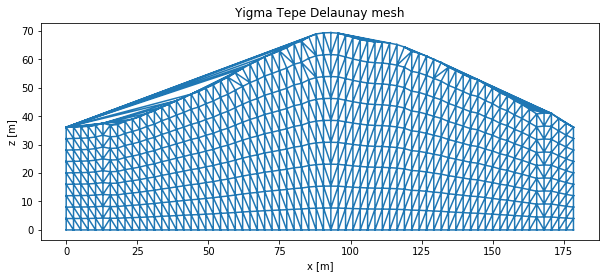

In [8]:
# Plot triangular mesh
plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
plt.title("Yigma Tepe Delaunay mesh" )
plt.xlabel("x [m]")
plt.ylabel("z [m]")
plt.axes().set_aspect('equal')
plt.show()

The regular triangulation within the tumulus looks reasonable. However, the Delaunay triangulation also added unwanted triangles above the topography. To solve this problem we have to use **constrained Delaunay triangulation** in order to restrict the triangulation to the model below the free-surface topography. Unfortunately, constrained Delaunay triangulation is not available within `SciPy`. 

However, there exists a `python` wrapper to the mesh generator [Triangle](http://www.cs.cmu.edu/~quake/triangle.html) by Richard Shewchuck. This wrapper can be installed by 

* `git clone --depth=1 https://github.com/drufat/triangle.git`
* `cd triangle`
* `python setup.py install`

A detailed documentation of the Triangle Python wrapper by [Dzhelil Rufat](http://dzhelil.info/index.html) can be found [here](http://dzhelil.info/triangle/).

In [9]:
# import triangulate library
from triangle import triangulate, show_data, plot as tplot
import triangle

In order to use the constrained Delaunay triangulation, we obviously have to define the constraining vertex points lying on the boundaries of our model. In this case it is quite easy, because the TFI mesh is regular. 

OK, perhaps not so easy, because we have to be sure that no redundant points are in the final list and the points are sequentially defined in clockwise direction.

In [10]:
# Estimate boundary points 

# surface topography
surf = np.vstack([X[9,:-2],Z[9,:-2]]).T

# right model boundary
right = np.vstack([X[1:,69],Z[1:,69]]).T

# bottom model boundary
bottom = np.vstack([X[0,1:],Z[0,1:]]).T

# left model boundary
left = np.vstack([X[:-2,0],Z[:-2,0]]).T

# assemble model boundary
model_stack = np.vstack([surf,np.flipud(right)])
model_stack1 = np.vstack([model_stack,np.flipud(bottom)])
model_bound = np.vstack([model_stack1,left])

The above code looks a little bit chaotic, but you can check that the points in the resulting array *model_bound* are correctly sorted and contains no redundant points. 

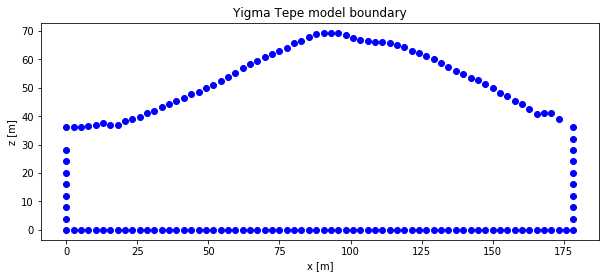

In [11]:
plt.plot(model_bound[:,0],model_bound[:,1],'bo')
plt.title("Yigma Tepe model boundary" )
plt.xlabel("x [m]")
plt.ylabel("z [m]")
plt.axes().set_aspect('equal')
plt.show()


Good, now we have defined the model boundary points. Time for some **constrained Delaunay triangulation** ...

In [12]:
# define vertices (no redundant points)
vert = model_bound

# apply Delaunay triangulation to vertices
tri = triangle.delaunay(vert)

# define vertex markers
vertm = np.array(np.zeros((len(vert),1)),dtype='int32')

# define how the vertices are connected, e.g. point 0 is connected to point 1, 
# point 1 to point 2 and so on ... 
points1 = np.arange(len(vert))
points2 = np.arange(len(vert))+1

# last point is connected to the first point
points2[-1] = 0

# define connectivity of boundary polygon
seg = np.array(np.vstack([points1,points2]).T,dtype='int32')

# define marker for boundary polygon
segm = np.array(np.ones((len(seg),1)),dtype='int32')

# assemble dictionary for triangle optimisation
A = dict(vertices=vert, vertex_markers=vertm, segments=seg, segment_markers=segm,triangles=tri)

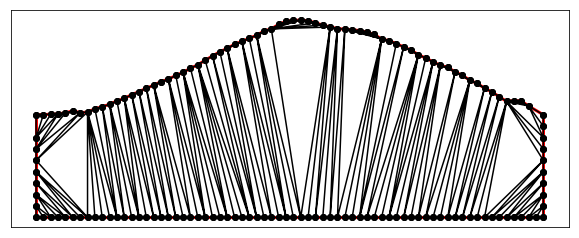

In [13]:
# Optimise initial triangulation
cndt = triangle.triangulate(A,'pD')
ax = plt.subplot(111, aspect='equal')
tplot.plot(ax,**cndt)

Very good, compared to the `SciPy` Delaunay triangulation, no triangles are added above the topography. However, most triangles have very small minimum angles, which would lead to serious numerical issues in later finite element modelling runs. So in the next step we restrict the minimum angle to 20° using the option `q20`.

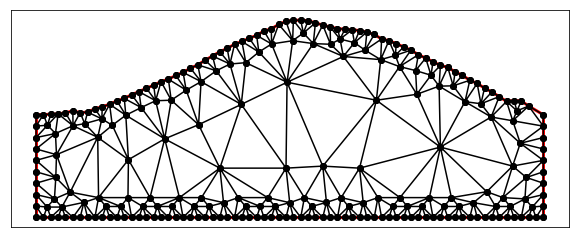

In [14]:
cncfq20dt = triangulate(A,'pq20D')
ax = plt.subplot(111, aspect='equal')
tplot.plot(ax,**cncfq20dt)

Finally, we want a more evenly distribution of the triangle sizes. This can be achieved by imposing a maximum area to the triangles with the option `a20`.

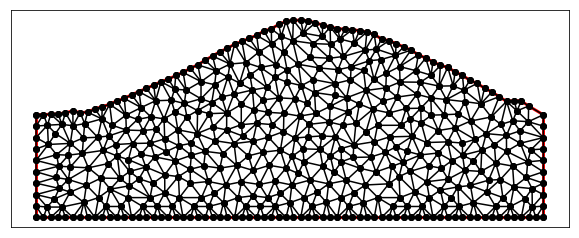

In [15]:
cncfq20adt = triangulate(A,'pq20a20D')
ax = plt.subplot(111, aspect='equal')
tplot.plot(ax,**cncfq20adt)

Compared to the `SciPy` Delaunay triangulation, the optimized mesh created by constrained Delaunay triangulation correctly describes the free-surface topography and can be used for modelling of seismic wave propagation with finite element or finite volume methods.

## Mesh generators

We have seen, that mesh generation from scratch can be quite time-consuming, even for a simple model geometry. Therefore, it is recommended to use mesh generators. Here, I summarize a few of the most popular codes:

* [CUBIT](https://cubit.sandia.gov/) developed by Sandia national laboratories, CUBIT is the most widely used mesh generator. A disadvantage of the code is that it is only available for users employed in the US government.

* [TRELIS](https://www.csimsoft.com/trelis.jsp) This is the international version of CUBIT. However, it has an annual lease license.

As mentioned in the introduction, my philosopy is that science should rely on OpenSource codes in order to achieve reproducible research. Therefore, I prefer OpenSource meshers, e.g.:

* [Gmsh](http://gmsh.info/) developed by Christophe Geuzaine and Jean-François Remacle, Gmsh can create triangular, tetrahedral, quad and hex meshes. Gmsh also has some visualization capabilites for post-processing.

* [Tetgen](http://wias-berlin.de/software/index.jsp?id=TetGen&lang=1) developed by Hang Si, can produce tetrahedral meshes. 

* We already used [Triangle](https://www.cs.cmu.edu/~quake/triangle.html) together with a Python wrapper in this Jupyter notebook to create a 2D triangular mesh for the Yigma Tepe tumulus. More complex triangular meshes can also be created with Triangle. 

* Another nice Python interface for Triangle and Tetgen is [MeshPy](https://mathema.tician.de/software/meshpy/) by Andreas Klöckner.

## We learned:

* How to read and display an external regular TFI mesh for the Yigma Tepe tumulus
* Building a Voronoi diagram and triangular Delaunay mesh based on the regular TFI quad mesh node points
* Building a triangular mesh for the Yigma Tepe tumulus from scratch using constrained Delaunay triangulation
* Triangular mesh generation is even more time-consuming than for the quad mesh
* For complex 2D/3D model geometries it is recommend to use a mesh generator like Gmsh , Triangle or Tetgen